In [137]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# **Always run all imported notebooks when you make a change in some files you imported.**

### Adam Candrák/Mária Matušisková - 50%/50%

# Imports

In [138]:
import import_ipynb
import connections
import devices
import normalize
import processes
import profiles

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from collections import Counter
from sklearn.model_selection import train_test_split


Just for test purposes to check if the import of jupyter notebooks was successful.

In [139]:
connections.test()
devices.test()
processes.test()
profiles.test()

Success
Success
Success
Success


# Phase 1 - Exploratory analysis

-------------------------------------------------------------------------------------------

## 2.1 Data Preparation

Change the names of columns of connections dataset:

In [140]:
c_connections = connections.connections.rename(columns={
    "c.katana": "facebook",
    "c.android.chrome": "chrome",
    "c.android.gm": "gmail",
    "c.dogalize": "dogalize",
    "c.android.youtube": "youtube",
    "c.updateassist": "updateassist",
    "c.UCMobile.intl": "UCMobile.intl",
    "c.raider": "raider",
    "c.android.vending": "vending",
    "c.UCMobile.x86": "UCMobile.x86",
})

Change the names of columns of processes dataset:

In [141]:
p_processes = processes.processes.rename(columns={
    "p.katana": "facebook",
    "p.android.chrome": "chrome",
    "p.android.gm": "gmail",
    "p.dogalize": "dogalize",
    "p.android.vending": "vending",
    "p.android.packageinstaller": "packageinstaller",
    "p.system": "system",
    "p.android.documentsui": "documentsui",
    "p.android.settings": "settings",
    "p.android.externalstorage": "externalstorage",
    "p.android.defcontainer": "defcontainer",
    "p.inputmethod.latin": "inputmethod.latin",
    "p.process.gapps": "gapps",
    "p.simulator": "simulator",
    "p.android.gms": "google mobile services (gms)",
    "p.google": "google",
    "p.olauncher": "olauncher",
    "p.browser.provider": "browser provider",
    "p.notifier": "notifier",
    "p.gms.persistent": "gms.persistent",
})

Change type of timestamp to int64 of connections dataset:

In [142]:
c_connections['ts'] = pd.to_datetime(c_connections['ts']).astype(np.int64)

Change type of timestamp to int64 of processes dataset:

In [143]:
p_processes['ts'] = pd.to_datetime(p_processes['ts']).astype(np.int64)

#### Merge datasets connections and processes:

In [144]:
new_dataset = pd.merge(c_connections, p_processes, on=['imei', 'ts', 'mwra'])
new_dataset.head()

,ts,imei,mwra,facebook_x,chrome_x,gmail_x,dogalize_x,youtube,updateassist,UCMobile.intl,...,dogalize_y,gapps,simulator,facebook_y,google mobile services (gms),google,olauncher,browser provider,notifier,gms.persistent
0,1525514400000000000,3590433799317662188,True,10.99774,11.05477,6.03999,12.49767,8.59956,14.00953,52.54470,...,95.23250,99.55387,82.64951,55.62534,43.73958,28.79282,8.22474,73.26391,25.28004,86.66346
1,1525514460000000000,3590433799317662394,True,11.08234,9.64636,8.64167,12.60788,9.84197,38.27736,44.56009,...,73.67809,55.93619,27.33158,68.28812,67.18486,19.40350,19.26265,58.69464,90.54099,33.10194
2,1525514520000000000,3590433799317661834,False,11.49582,12.27416,11.59681,12.99258,9.74923,57.41411,36.83333,...,49.43847,92.96630,54.04233,25.01599,57.15110,60.38043,16.88231,55.62452,16.82005,81.58652
3,1525514580000000000,8630330696303481289,False,10.50935,11.41774,14.43350,12.91018,13.93857,31.57549,41.34296,...,71.37356,8.34277,87.09809,5.21806,98.58641,97.22889,37.30215,68.75315,26.44336,79.98101
4,1525514640000000000,8630330696303481149,False,10.25989,14.46448,14.02728,8.58832,13.04853,49.47100,38.86755,...,14.58892,27.72954,81.20459,22.42807,25.06680,73.26831,43.72205,78.80356,16.55350,75.03307


In [145]:
new_dataset

,ts,imei,mwra,facebook_x,chrome_x,gmail_x,dogalize_x,youtube,updateassist,UCMobile.intl,...,dogalize_y,gapps,simulator,facebook_y,google mobile services (gms),google,olauncher,browser provider,notifier,gms.persistent
0,1525514400000000000,3590433799317662188,True,10.99774,11.05477,6.03999,12.49767,8.59956,14.00953,52.54470,...,95.23250,99.55387,82.64951,55.62534,43.73958,28.79282,8.22474,73.26391,25.28004,86.66346
1,1525514460000000000,3590433799317662394,True,11.08234,9.64636,8.64167,12.60788,9.84197,38.27736,44.56009,...,73.67809,55.93619,27.33158,68.28812,67.18486,19.40350,19.26265,58.69464,90.54099,33.10194
2,1525514520000000000,3590433799317661834,False,11.49582,12.27416,11.59681,12.99258,9.74923,57.41411,36.83333,...,49.43847,92.96630,54.04233,25.01599,57.15110,60.38043,16.88231,55.62452,16.82005,81.58652
3,1525514580000000000,8630330696303481289,False,10.50935,11.41774,14.43350,12.91018,13.93857,31.57549,41.34296,...,71.37356,8.34277,87.09809,5.21806,98.58641,97.22889,37.30215,68.75315,26.44336,79.98101
4,1525514640000000000,8630330696303481149,False,10.25989,14.46448,14.02728,8.58832,13.04853,49.47100,38.86755,...,14.58892,27.72954,81.20459,22.42807,25.06680,73.26831,43.72205,78.80356,16.55350,75.03307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13808,1526408820000000000,863033069630348123,True,13.31200,15.71180,13.40696,10.90627,15.05067,52.86111,49.79239,...,5.97424,10.90052,64.04619,80.00079,78.87558,33.74537,60.31124,89.11008,46.41420,10.20768
13809,1526408940000000000,3590433799317661594,True,13.52429,13.82647,13.60043,11.46229,17.82659,27.86611,25.41132,...,7.86586,66.80404,9.30436,52.73032,9.57537,37.50921,36.65184,97.34896,38.01707,6.64068
13810,1526409000000000000,8630330696303481057,False,10.90390,8.77998,15.71295,14.06695,14.61081,36.67428,47.42102,...,72.41636,99.40362,3.27873,90.70094,51.97068,10.63735,23.57597,81.81312,77.31911,61.81489
13811,1526409060000000000,3590433799317662188,True,8.47958,8.11147,15.36153,4.71766,12.32035,55.91226,48.17744,...,45.63483,44.30156,83.10716,2.99819,1.73479,44.51363,66.19054,76.48819,27.12469,5.60833


#### Data cleaning:

Find negative values in the merged dataset:

In [146]:
negative_values = new_dataset.select_dtypes(include=[np.number]) < 0

# any for columns and all values in the series of the first any
has_negatives = negative_values.any().any()

if has_negatives:
    print("The dataset has negative values.")
    print(negative_values.any())  
else:
    print("No negative values found in the dataset.")

No negative values found in the dataset.


Find NaN values in the merged dataset:

In [147]:
has_nan = new_dataset.isnull().values.any()

if has_nan:
    print("The dataset has NaN values.")
    print(new_dataset.isnull().values)
else:
    print("No NaN values found in the dataset.")

No NaN values found in the dataset.


Find duplicity values in the merged dataset:

In [148]:
has_duplicity = new_dataset.duplicated().any()

if has_duplicity:
    print("The dataset has duplicity values.")
    print(new_dataset[new_dataset.duplicated()])
    print("Number of duplicate rows:", new_dataset.duplicated().sum())
else:
    print("No duplicity values found in the dataset.")

No duplicity values found in the dataset.


Drop values which are not helpful for further training:

In [149]:
new_dataset.drop('ts', axis=1, inplace=True)
new_dataset.drop('imei', axis=1, inplace=True)

-------------------------------------------------------------------------------------------
### 2.1 B - Data integration
-------------------------------------------------------------------------------------------

#### Standard Deviation 
- detect outliers by standard deviation which spreads data around the mean
- **3x standard deviations ($\sigma$) from the mean ($\mu$)**

In [150]:
new_dataset.shape

(13813, 31)

In [151]:
# Source: https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

def StandardDevDetection(data, n, columns):
    
    outliers_inx = []
    lower = 0
    upper = 0

    for column in columns:
        # Calculate mean and standard derivation of each column
        data_mean, data_std = mean(data[column], axis=0), std(data[column], axis=0)
        print('column=', column, 'len=', len(data), 'mean=', data_mean, 'std=', data_std)

        # Divide it to the three outliers in the standard deviations:
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        print('column=', column, 'cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

        # Filter the dataframe:
        outliers = data[(data[column] < lower) | (data[column] > upper)].index
        print('Identified outliers:', len(outliers))
        
        outliers_inx.extend(outliers)

    outliers_inx = Counter(outliers_inx)
    multiple_outliers = list( k for k, v in outliers_inx.items() if v > n )

    data_uppper = data[data[column] > upper]
    data_lower = data[data[column] < lower]
    print('Total number of outliers is:', data_uppper.shape[0] + data_lower.shape[0])
    
    return multiple_outliers


columns = new_dataset.columns
result = StandardDevDetection(new_dataset, 1, columns)

new_dataset = new_dataset.drop(result, axis = 0).reset_index(drop=True)

column= mwra len= 13813 mean= 0.6411351625280532 std= 0.4796674534489284
column= mwra cutoff= 1.4390023603467852 lower= -0.7978671978187319 upper= 2.080137522874838
Identified outliers: 0
column= facebook_x len= 13813 mean= 10.960814784623182 std= 2.6473283821315765
column= facebook_x cutoff= 7.94198514639473 lower= 3.0188296382284516 upper= 18.90279993101791
Identified outliers: 2
column= chrome_x len= 13813 mean= 11.539096789256499 std= 2.5207614078254665
column= chrome_x cutoff= 7.5622842234764 lower= 3.976812565780099 upper= 19.1013810127329
Identified outliers: 2
column= gmail_x len= 13813 mean= 12.271741594150438 std= 2.5156002578552674
column= gmail_x cutoff= 7.546800773565803 lower= 4.724940820584635 upper= 19.81854236771624
Identified outliers: 12
column= dogalize_x len= 13813 mean= 10.471127016578587 std= 2.192478595551923
column= dogalize_x cutoff= 6.5774357866557684 lower= 3.893691229922818 upper= 17.048562803234354
Identified outliers: 20
column= youtube len= 13813 mean= 1

Divide it to the three outliers in the standard deviations:

In [152]:
new_dataset.shape

(13812, 31)

Show data distribution after cut of outlines:

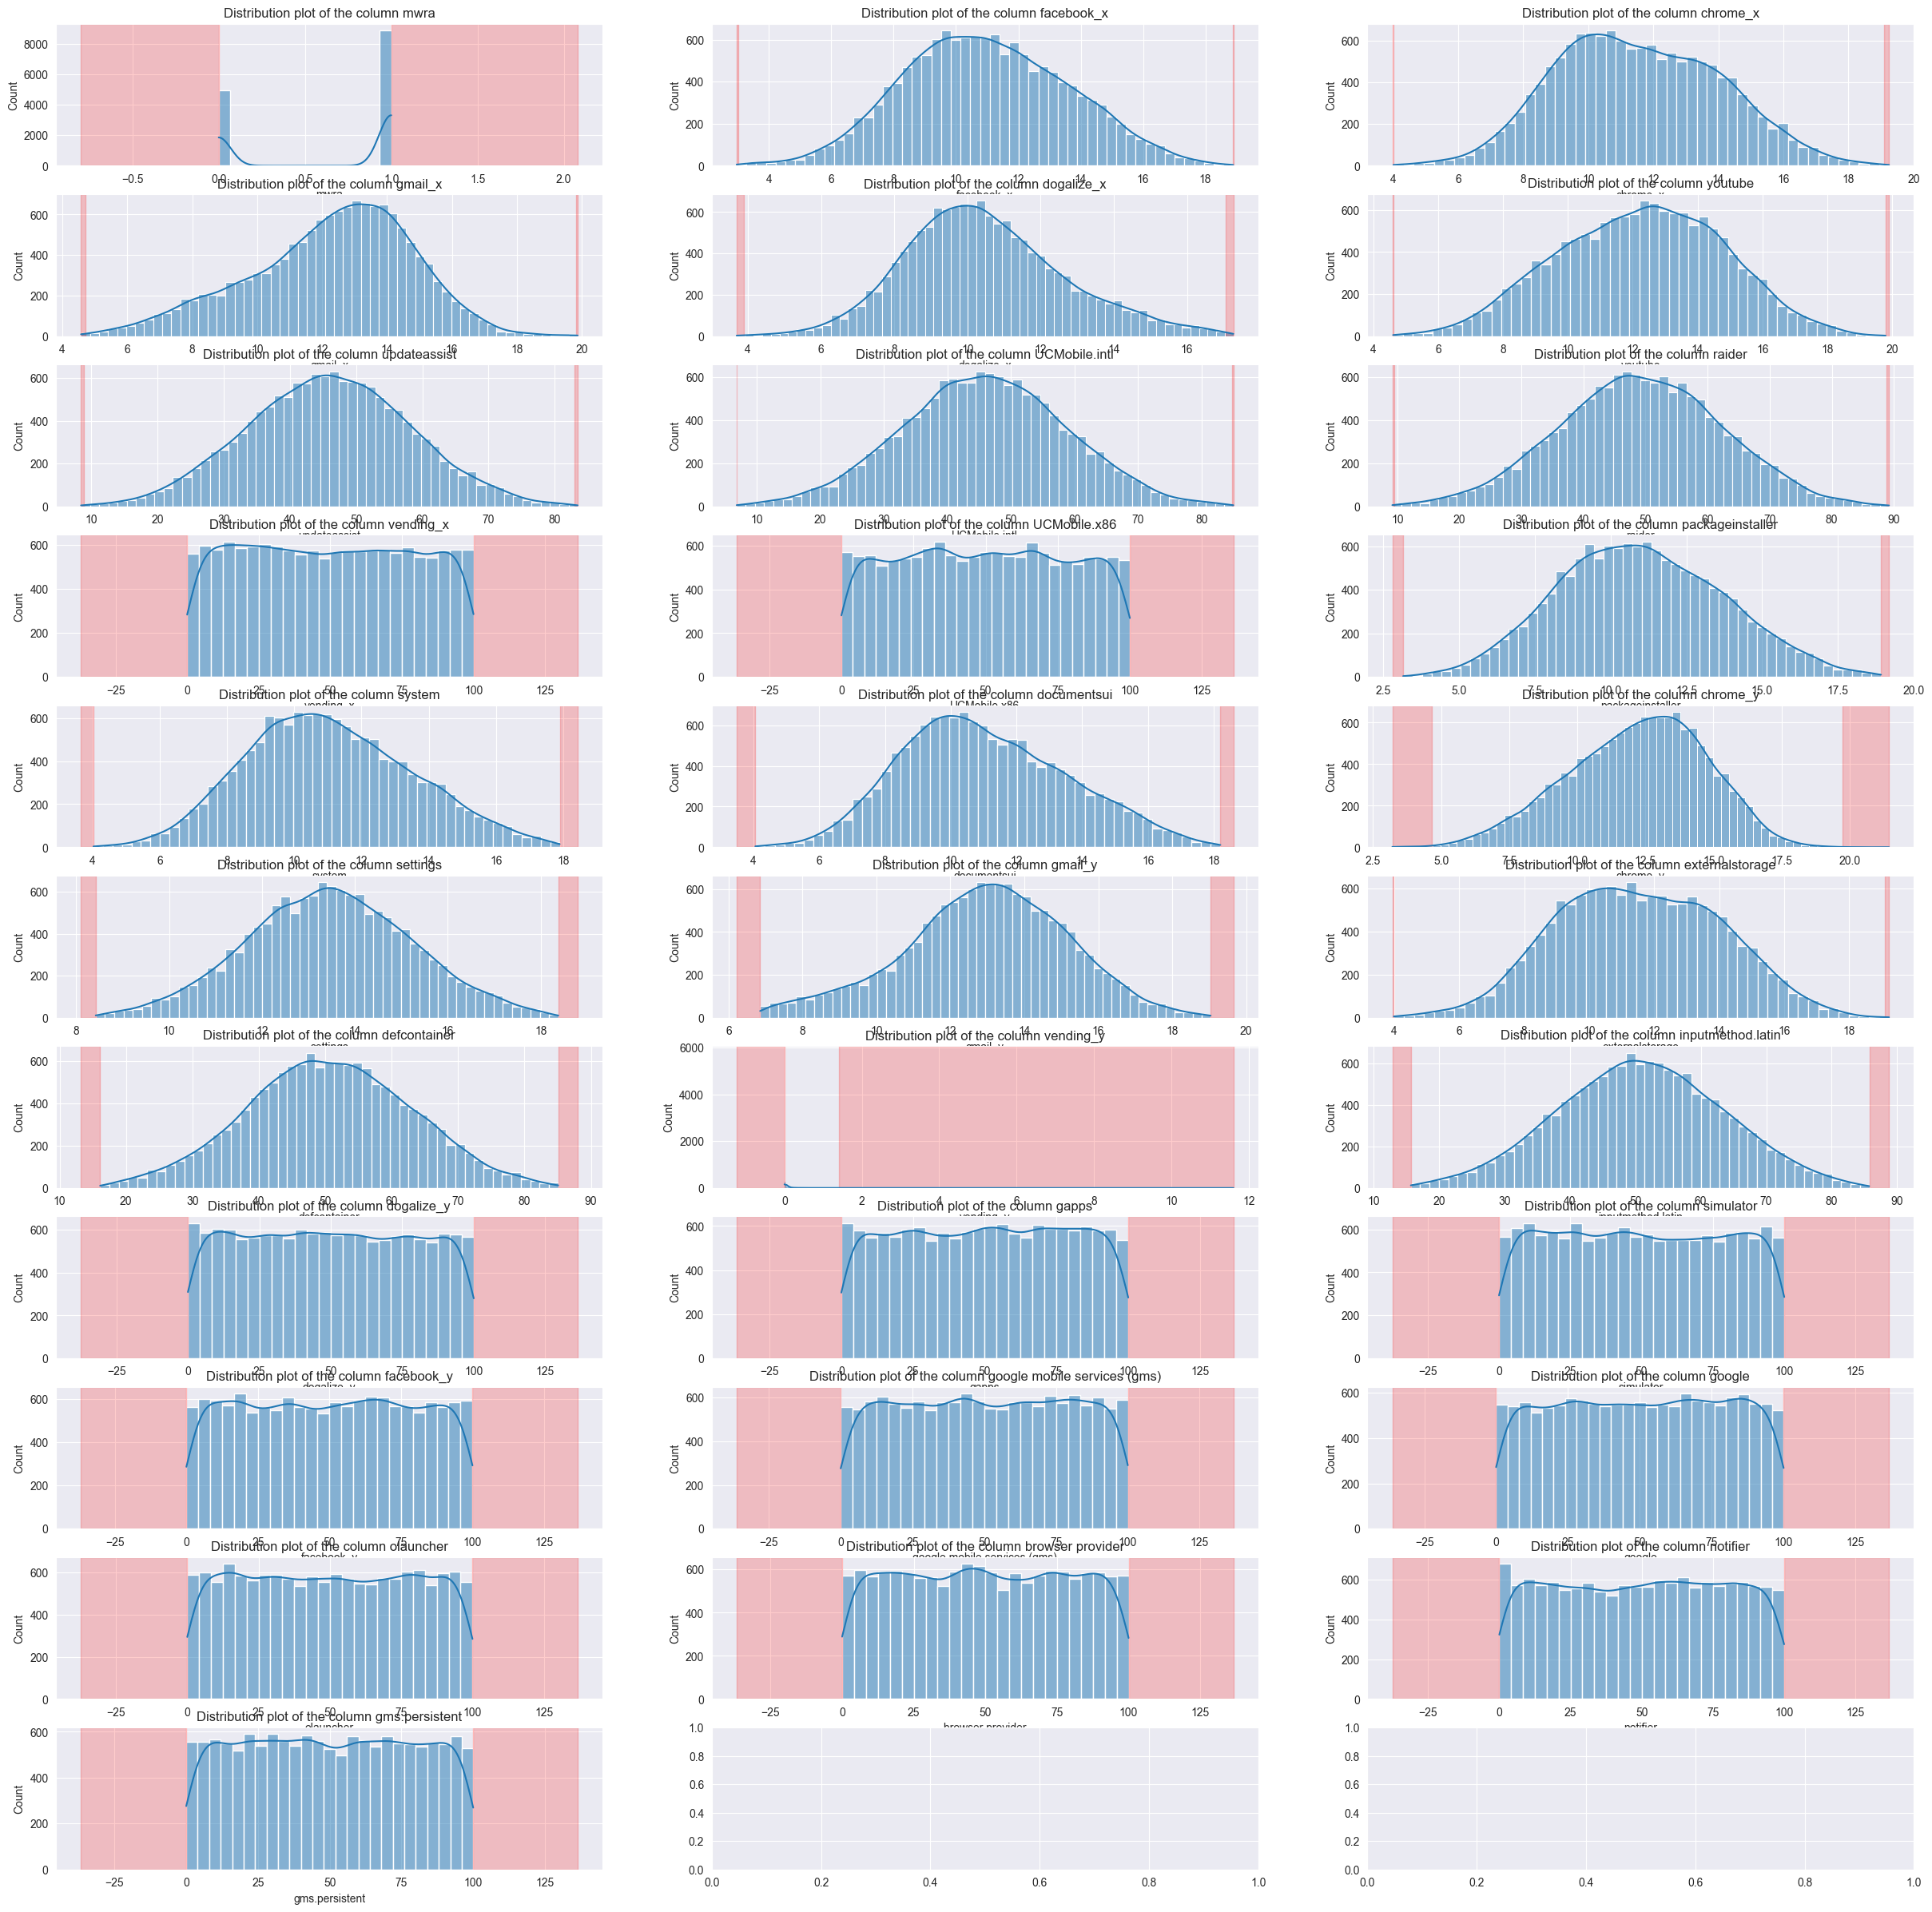

In [153]:
columns = new_dataset.columns

fig, axes = plt.subplots(nrows=(len(columns)//2) - 4, ncols=3, figsize=(30, 30))

axes = axes.flatten()

for i, col in enumerate(columns):
    data_mean, data_std = mean(new_dataset[col], axis=0), std(new_dataset[col], axis=0)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    sns.histplot(new_dataset[col], kde=True, ax=axes[i])
    axes[i].axvspan(xmin = lower,xmax= new_dataset[col].min(),alpha=0.2, color='red')
    axes[i].axvspan(xmin = upper,xmax= new_dataset[col].max(),alpha=0.2, color='red')
    axes[i].set_title(f'Distribution plot of the column {col}')


-------------------------------------------------------------------------------------------
## 2.1 A - Split dataset on Train and Test data
-------------------------------------------------------------------------------------------

In [154]:
new_dataset.columns

Index(['mwra', 'facebook_x', 'chrome_x', 'gmail_x', 'dogalize_x', 'youtube',
       'updateassist', 'UCMobile.intl', 'raider', 'vending_x', 'UCMobile.x86',
       'packageinstaller', 'system', 'documentsui', 'chrome_y', 'settings',
       'gmail_y', 'externalstorage', 'defcontainer', 'vending_y',
       'inputmethod.latin', 'dogalize_y', 'gapps', 'simulator', 'facebook_y',
       'google mobile services (gms)', 'google', 'olauncher',
       'browser provider', 'notifier', 'gms.persistent'],
      dtype='object')

In [155]:
target_column = 'mwra'
mwra = new_dataset[target_column]
data = new_dataset.drop(columns=[target_column], axis=1)

In [156]:
train_data, test_data, train_mwra, test_mwra = train_test_split(data, mwra, test_size=0.3, random_state=42)

-------------------------------------------------------------------------------------------
### 2.1 B Data transformation
-------------------------------------------------------------------------------------------

##### One-hot Encoding Binary Columns

In [157]:
# Source: IAU week-05

import category_encoders as ce

# create object of BinaryEncoder
ce_binary = ce.BinaryEncoder(cols = ['mwra'])

# fit and transform and you will get the encoded data
ce_binary.fit_transform(train_mwra)

,mwra_0,mwra_1
652,0,1
7157,0,1
6889,1,0
3473,0,1
7855,1,0
...,...,...
5191,0,1
13418,0,1
5390,0,1
860,1,0


-------------------------------------------------------------------------------------------
### 2.1 C - Scaling
-------------------------------------------------------------------------------------------

#### 2.1 C - Data normalization

## $x_{normalization}=\frac{x-x_{min}}{x_{max} - x_{min}}$

It is good to use, when in the data is a wide range of values. Which cal lead to poor performance of models. Which is our case true. We compare the data and the range was wild.

In [158]:
# Source: IAU week-05

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()

# transform data
train_data = scaler.fit_transform(train_data)
print(train_data)

[[0.46532684 0.65435847 0.55473366 ... 0.53938962 0.49548575 0.62505231]
 [0.60720181 0.69866849 0.52712396 ... 0.12748244 0.88609364 0.78160951]
 [0.73288585 0.42310005 0.69813909 ... 0.38497812 0.05838268 0.10333648]
 ...
 [0.64515966 0.26155698 0.67604713 ... 0.78394989 0.04566846 0.05384304]
 [0.82642756 0.7422867  0.78437034 ... 0.02611836 0.04168749 0.18057928]
 [0.13805188 0.41466245 0.67943943 ... 0.20407831 0.31411581 0.07042059]]


The result is in the numpy python format, which is the best format for training because is fast and intuitive compare to normal array.


#### 2.1 C - Data standardization

## $x_{standardized} = \frac{x -\mu}{\sigma}$
where 
- $\mu$ is the mean  of $x$
- $\sigma$ is the standard deviation of $x$

It is a z-normalization, it measures variations of values about its mean in the dataset. (in short it measures the range of values)


In [159]:
# Source: IAU week-05

from numpy import asarray
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler = StandardScaler()

# transform data
train_data = scaler.fit_transform(train_data)
print(train_data)

[[-0.20557775  0.97134471  0.31782819 ...  0.13780638 -0.00572436
   0.44732815]
 [ 0.64328479  1.23901303  0.15030506 ... -1.29079333  1.34329243
   0.98932587]
 [ 1.39527425 -0.42564303  1.18794721 ... -0.39773229 -1.51531848
  -1.35884116]
 ...
 [ 0.87039321 -1.40149367  1.05390321 ...  0.98600408 -1.55922877
  -1.53018642]
 [ 1.9549505   1.50250226  1.71115928 ... -1.64234991 -1.57297759
  -1.09142821]
 [-2.16372059 -0.47661293  1.07448615 ... -1.02513921 -0.63210981
  -1.47279529]]


-------------------------------------------------------------------------------------------
### 2.1 C - Make data distribution more Gaussian :3
-------------------------------------------------------------------------------------------

#### Power transformer 🤖 on random data -> Yeo-Johnson Transform with Linear Regression
- to have more relatively similar to normally distributed

This text is from the week-05:
- Replacing the data with the log, square root, or inverse to remove skew
- Yeo-Johnson transform (default): works with positive and negative values
- Box-Cox transform: only works with strictly positive values
- λ = −1.0 is a reciprocal transform.
- λ = −0.5 is a reciprocal square root transform.  
- λ = 0.0 is a log transform.
- λ = 0.5 is a square root transform.
- λ = 1.0 is no transform.

[ 0.34864666  0.75702145  1.19356046 ...  0.14955885  1.0200397
 -0.0674294 ]


Text(0.5, 1.0, 'Actual vs. Predicted Values')

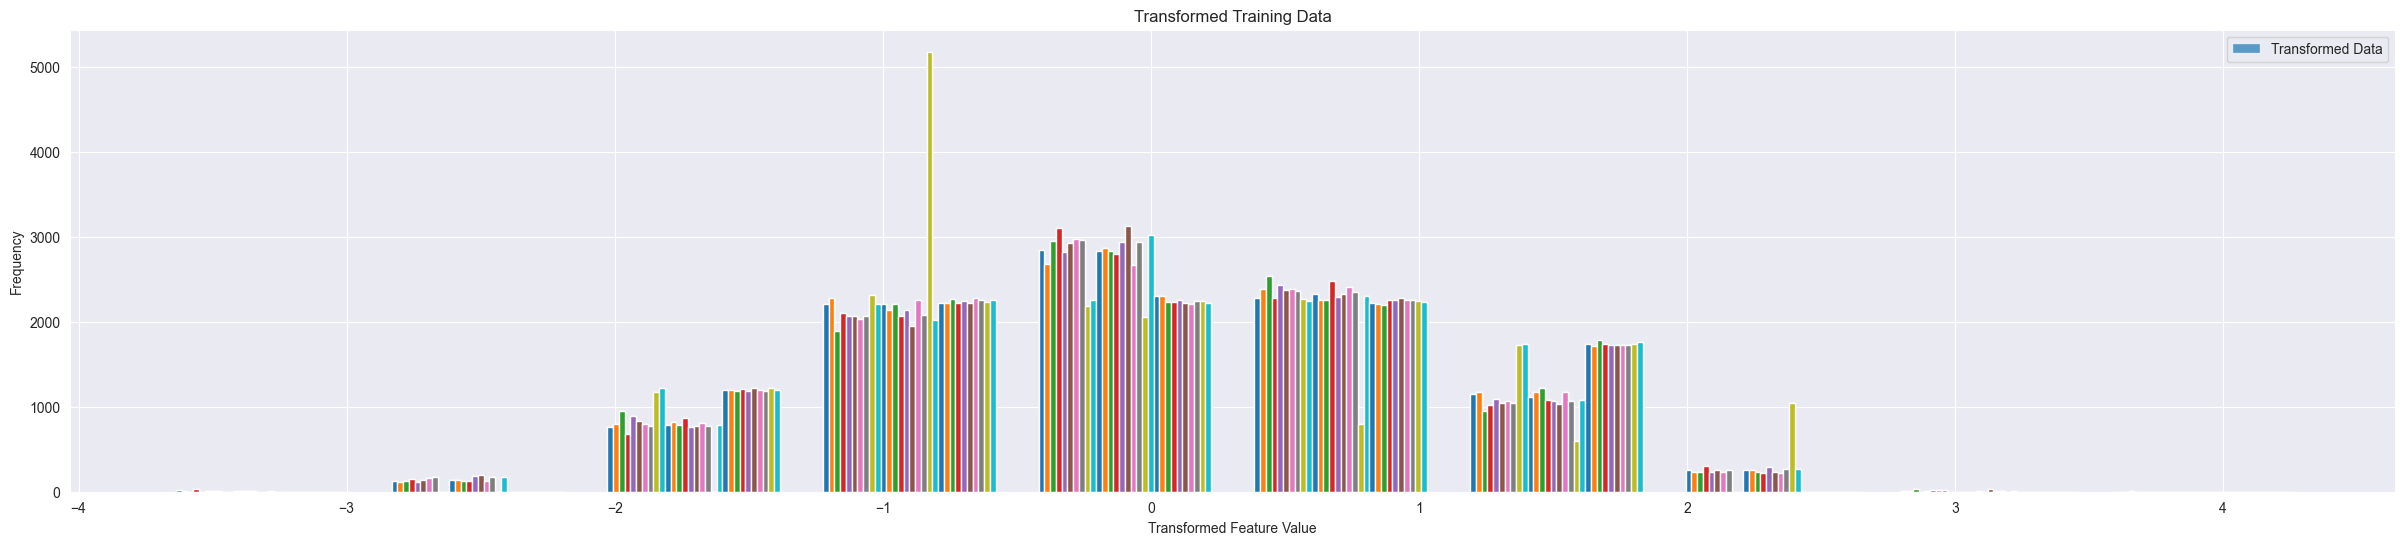

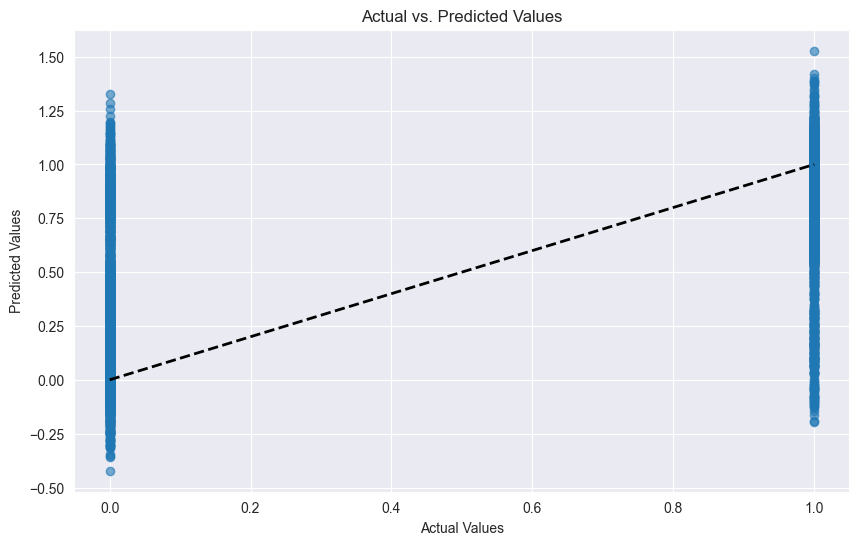

In [160]:
# Source: https://www.kaggle.com/code/abhikuks/power-transformers-in-depth-understanding

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

plt.figure(figsize=(30, 6))

pt = PowerTransformer()
train_data = pt.fit_transform(train_data)
pyplot.hist(train_data, bins=10)

lr = LinearRegression()
lr.fit(train_data, train_mwra)

# let's make some basic prediction on mwra
predictions = lr.predict(train_data)
print(predictions)

# show trained transformed data in the histogram graph of normalized data
plt.hist(train_data, bins=10, alpha=0.7, label='Transformed Data')
plt.legend()
plt.xlabel('Transformed Feature Value')
plt.ylabel('Frequency')
plt.title('Transformed Training Data')
pyplot.hist(train_data, bins=10)

# show prediction
plt.figure(figsize=(10, 6))
plt.scatter(train_mwra, predictions, alpha=0.6)
plt.plot([train_mwra.min(), train_mwra.max()], [train_mwra.min(), train_mwra.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')


-------------------------------------------------------------------------------------------
#### 2.1 C - Data discretization 
-------------------------------------------------------------------------------------------
- to reduce the effects of minor observation errors
- minimalize the influence of outliers

##### Equal-width dicretization

- I chose this discretization, because in the data is still wide range between values and thus this could be a solution to cut range into the smaller intervals. It is called equally sized intervals.

   UCMobile.intl  UCMobile.x86  browser provider  chrome_x  chrome_y  \
0      -0.181321      0.972890          0.241332 -1.276260  0.699751   
1       0.657329      1.221884          0.061906 -1.160234  0.488790   
2       1.372745     -0.398914          1.261810 -0.009411  0.046208   
3       1.192256      1.812179          0.603669 -0.082979  0.361015   
4       0.769890      0.653590          0.247782 -0.965535 -0.232938   

   defcontainer  documentsui  dogalize_x  dogalize_y  externalstorage  ...  \
0     -0.739406    -0.469795   -0.441742    0.038282        -0.073418  ...   
1     -1.698560     0.139838   -0.435248    1.313811         1.211166  ...   
2     -0.136036     2.348037    0.865578    0.733491         0.512880  ...   
3     -0.897243     1.189013    1.075504    0.909810        -1.335414  ...   
4      0.511585    -0.523282   -0.775557   -0.813942         0.589527  ...   

   olauncher_binned  packageinstaller_binned  raider_binned  settings_binned  \
0                 

Text(0, 0.5, 'Frequency')

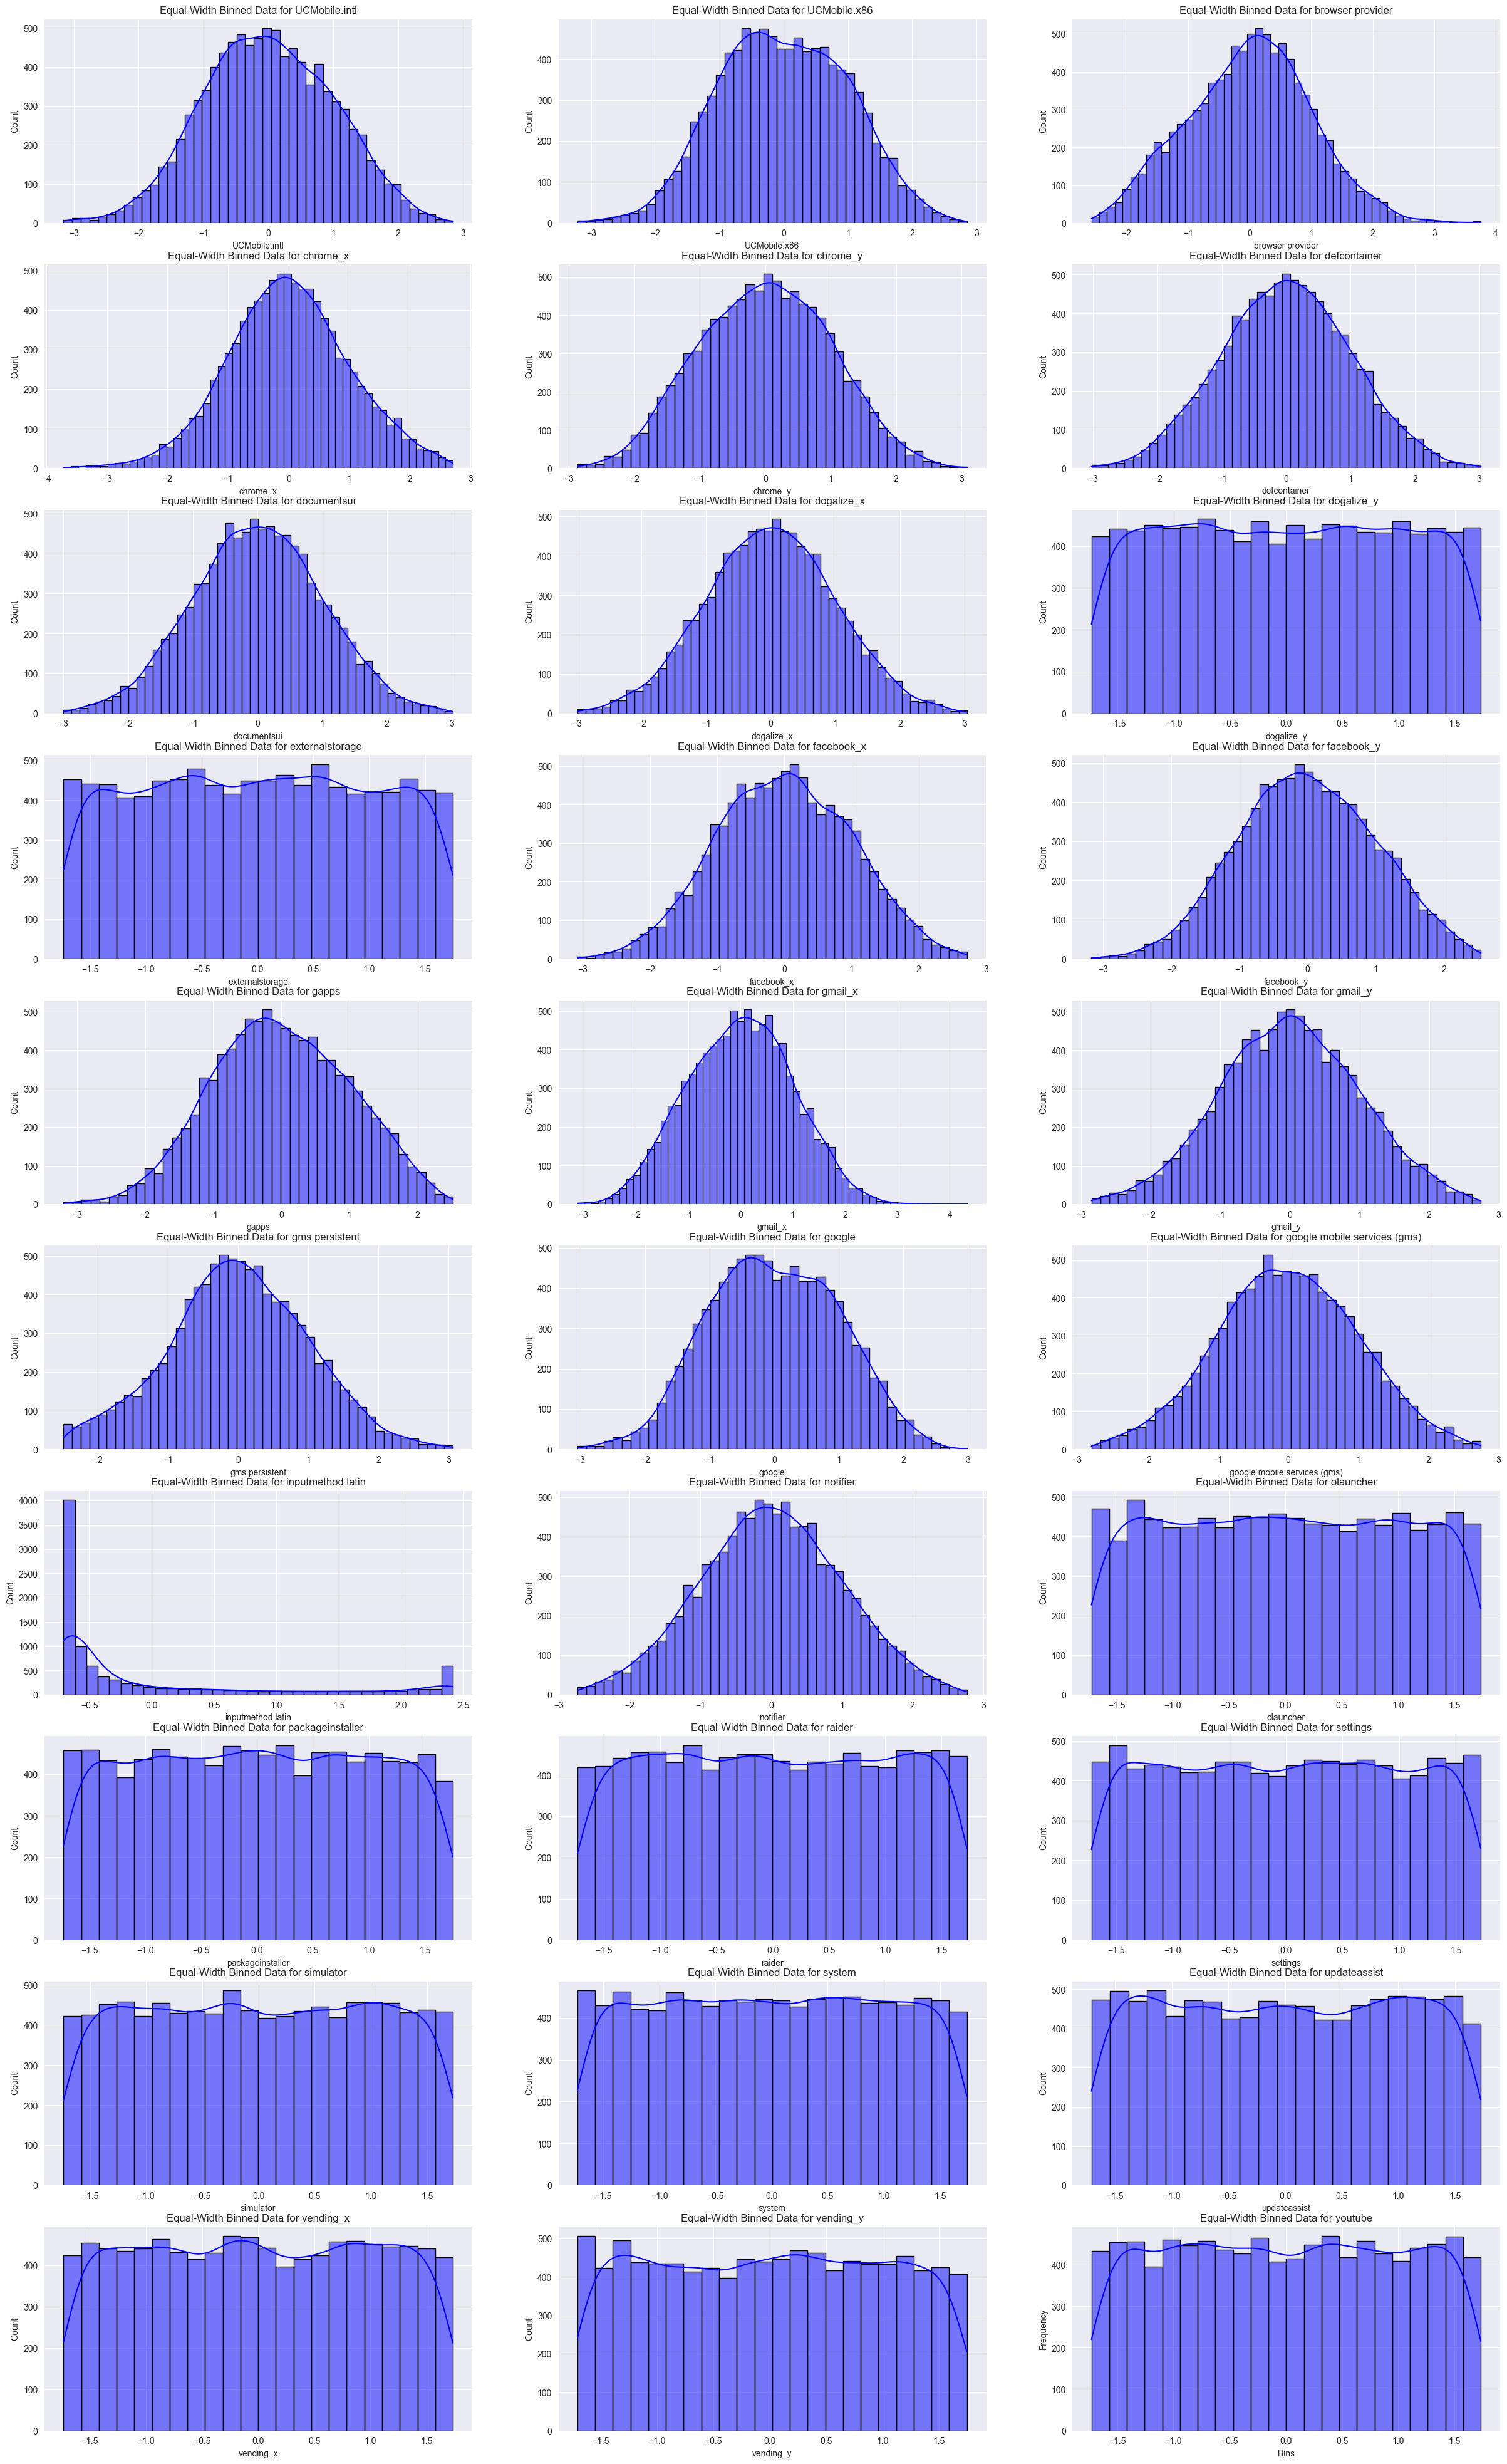

In [161]:
num_bins = 8

columns = columns.difference(['mwra'])
train_data = pd.DataFrame(train_data, columns=columns)

for column in train_data.select_dtypes(include=['float64', 'int64']).columns:
    train_data[f'{column}_binned'] = pd.cut(train_data[column], bins=num_bins, labels=False)

print(train_data.head())

fig, axes = plt.subplots(nrows=(len(columns)//2) - 5, ncols=3,figsize=(30, 50))
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.histplot(train_data[col], kde=True, ax=axes[i], color='blue', edgecolor='black')
    axes[i].set_title(f'Equal-Width Binned Data for {col}')
plt.xlabel('Bins')
plt.ylabel('Frequency')

-------------------------------------------------------------------------------------------
#### 2.1 C -  VarianceTreshold - to remove low variance values
-------------------------------------------------------------------------------------------

First, find the treshold range:

In [162]:
train_data.shape

(9668, 60)

In [163]:
train_data.var()

UCMobile.intl                          1.000103
UCMobile.x86                           1.000103
browser provider                       1.000103
chrome_x                               1.000103
chrome_y                               1.000103
defcontainer                           1.000103
documentsui                            1.000103
dogalize_x                             1.000103
dogalize_y                             1.000103
externalstorage                        1.000103
facebook_x                             1.000103
facebook_y                             1.000103
gapps                                  1.000103
gmail_x                                1.000103
gmail_y                                1.000103
gms.persistent                         1.000103
google                                 1.000103
google mobile services (gms)           1.000103
inputmethod.latin                      1.000103
notifier                               1.000103
olauncher                              1

In [164]:
var = VarianceThreshold(0.05)

In [165]:
train_data = var.fit_transform(train_data)
train_data

array([[-0.18132051,  0.97289012,  0.24133158, ...,  4.        ,
         3.        ,  5.        ],
       [ 0.65732855,  1.22188449,  0.06190627, ...,  1.        ,
         7.        ,  6.        ],
       [ 1.3727455 , -0.39891429,  1.26180965, ...,  3.        ,
         0.        ,  0.        ],
       ...,
       [ 0.87550913, -1.44076454,  1.09616144, ...,  6.        ,
         0.        ,  0.        ],
       [ 1.89422681,  1.46410276,  1.93321375, ...,  0.        ,
         0.        ,  1.        ],
       [-2.25128395, -0.45190431,  1.12141674, ...,  1.        ,
         2.        ,  0.        ]])

In [166]:
train_data.shape

(9668, 60)

-------------------------------------------------------------------------------------------
### 2.1 D - Reasons for implementation
-------------------------------------------------------------------------------------------

Some things are already indicated in the text. However, we decided to merge processes and connections into one dataset since they have common columns and values. They were merged on ts, imei and mwra, these columns they had absolutely identical. 
In the dataset, there are not anymore ts and imei columns, because they were not adequate for testing purposes and we considered them as unnecessary. 

Furthermore, we renamed the columns to better names for reading and better orientation during work. For example, the katana represents Facebook. Why not change it to right away? 

After merging for sure, we checked if the data are clean enough for further work.  

In our opinion, it is better to cut outliers before splitting the dataset. We also checked the presentation, and it was recommended to do it this way. After that, we split the dataset to train and test into two groups one is for all data and the second is for predicted value mwra. This way it is possible to predict how the mwra will behave. 

In conclusion, we prepared data for machine learning by data cleaning (missing values, outliers detection), integration (3x standard deviation, encoding) and transformation (scaling, transformers, discretization). Which ways we picked it are already defined in the specific sections.

--------------------------------

2.2 fesmognuigsbeglrirebl

<Axes: >

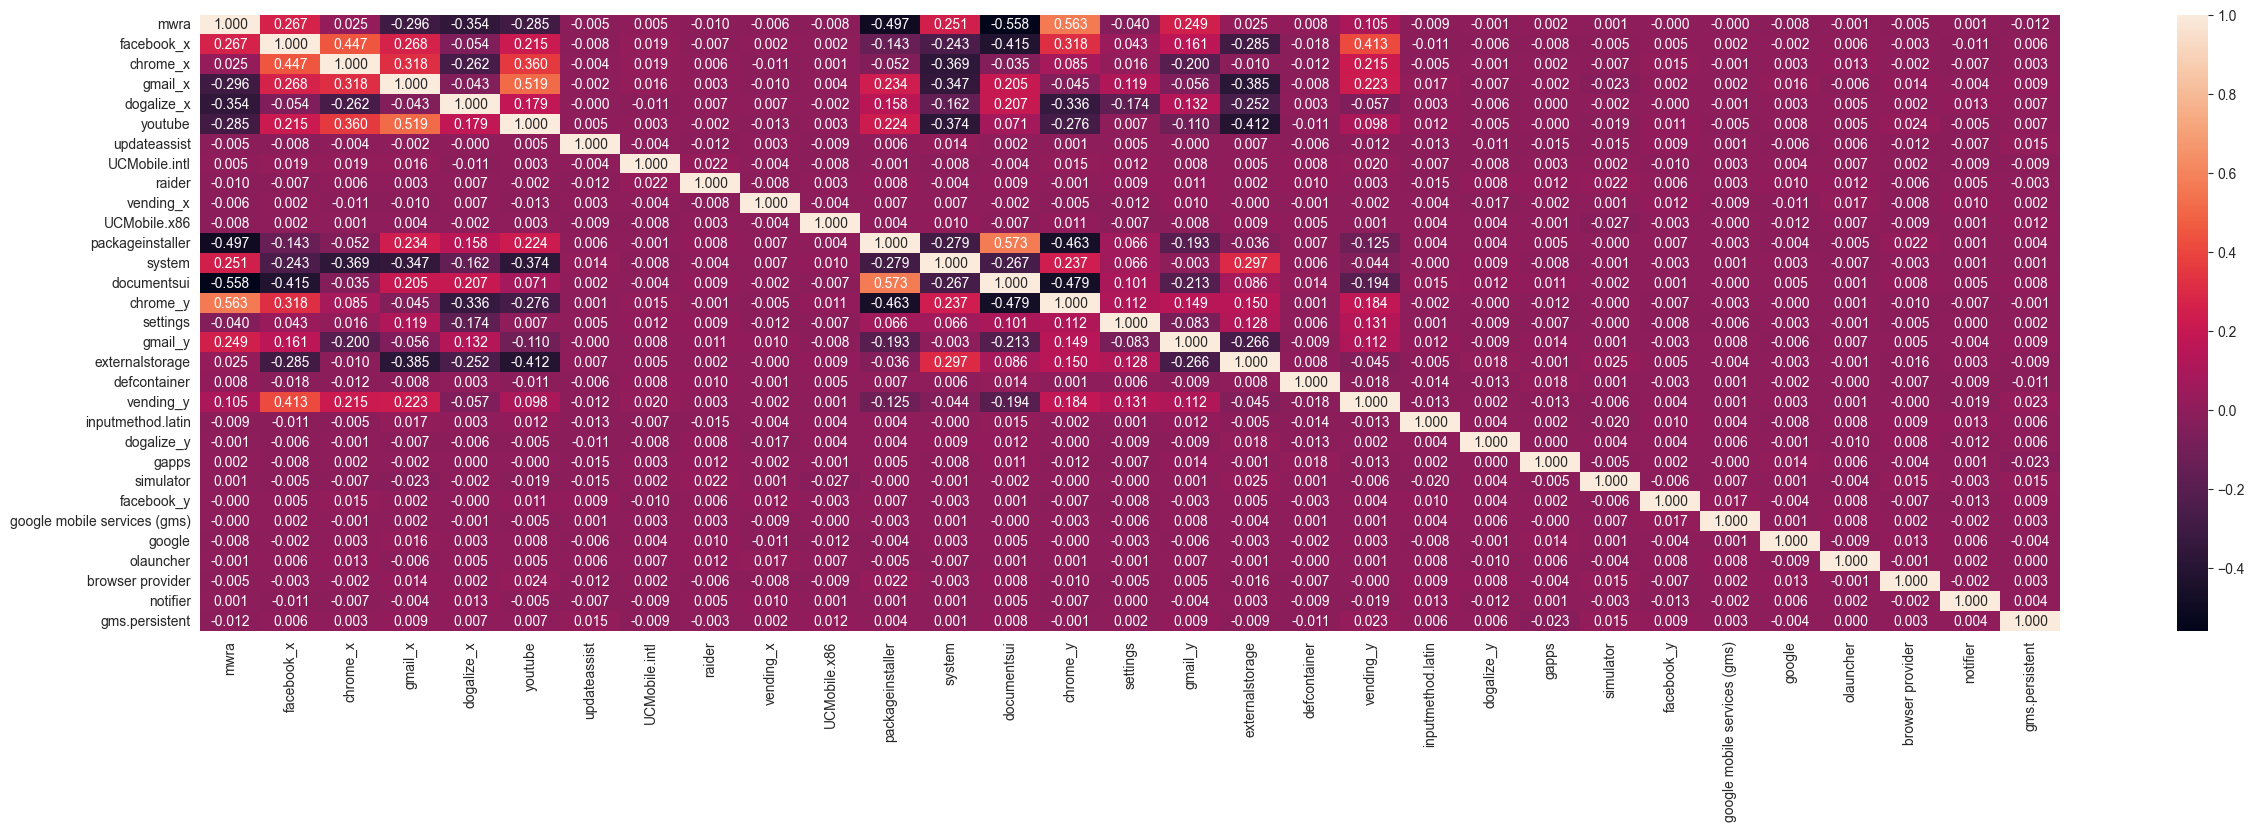

In [167]:
fig, ax = plt.subplots(figsize=(30,8))
sns.heatmap(new_dataset.corr(numeric_only=True), ax=ax, annot=True, fmt=".3f")